In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy
import os
import datetime
%matplotlib inline
mpl.rcdefaults()


In [3]:
df = pd.read_csv('.\datasets\current_data_without_preproc.csv')
df  = df.drop(columns=["Unnamed: 0.1","Unnamed: 0"])
# age_df = df["Age"].apply(np.floor)
# df["Age"] = df[["Age"]].replace(age_df[["Age"]], inplace=True)
# df
#print(df["Age"])
df.info()

numeric_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(exclude=[np.number])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4313 entries, 0 to 4312
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   EmployeeID                                  4313 non-null   object 
 1   Division                                    4313 non-null   object 
 2   Department                                  4313 non-null   object 
 3   CostCenterName                              4313 non-null   object 
 4   CostCenterCode                              4313 non-null   object 
 5   Location                                    4313 non-null   object 
 6   ResourceLevel                               4313 non-null   int64  
 7   JobTitle                                    4313 non-null   object 
 8   JobFunction                                 4310 non-null   object 
 9   Style                                       2160 non-null   object 
 10  Status      

In [4]:
def df_info(input_df):
    df_data = {}
    for column in list(input_df):
        data_to_append = {}
        # first sort through what type it is 
        ## Numerical data type workflow
        ## what if it's int32 or other variations? should i jsut convert this into a string then run .str.isnumeric operation on it?
        # using isinstance(x,int) would not work in pandas because pandas doesnt treat an int in the same way as in native python

        # Method 1 => hard code and account for all the possible dtypes 
        # Method 2 => convert dtypes to only int64 and float64, and manipulate from there

        if ('int' in input_df[f"{column}"].dtype) or ('float' in input_df[f"{column}"].dtype):
            data_to_append["Data Type"] = "Numerical"
            
            # range
            max_value = input_df[f"{column}"].max()
            min_value = input_df[f"{column}"].min()
            data_to_append["Range"] = str(min_value) + "-" + str(max_value)

        elif input_df[f"{column}"].dtype == "str" or input_df[f"{column}"].dtype == "O":
            data_to_append["Data Type"] = "Categorical"
            number_of_unique_values = input_df[f"{column}"].nunique()
            data_to_append["Unique Values"] = number_of_unique_values

        #datetime type
        elif input_df[f"{column}"].dtype == "datetime64":
            data_to_append["Data Type"] = "Date Time"

        elif input_df[f"{column}"].dtype == "bool":
            data_to_append["Data Type"] = "Boolean"

    # from there => add more details for each column respectively
        df_data[f"{column}"] = data_to_append
    
    return df_data

#print(df_info(df))

# output1 = {
#     "col a": {
#         "data type": "numeric/categorical/datetime" 
#         "if numeric - give range"
#         "if categorical - give number of unique values (i.e categories) " 
#     }
#     }

In [5]:
temp_df = df.copy(deep=True)
temp_df = temp_df[["Division", "Voluntary"]].dropna()
temp_df

,Division,Voluntary
0,Art Division,Yes
5,Game Division,No
13,GA Division,Yes
15,Game Division,Yes
33,GA Division,Yes
...,...,...
4306,Art Division,Yes
4307,Art Division,Yes
4308,Art Division,Yes
4310,Game Division,Yes


In [6]:
# FEATURES = ['Division','Department','CostCenterName','Location','ResourceLevel','JobTitle','JobFunction','Gender','Grade','MgrResourceLevel','Avg annual bonus vs monthly base salary (previous year) ','Avg quarterly people review rating (last 3 times)','Avg Extra time hours/week(6 mths)','Avg Idle day ratio/month (3 mths)','Avg Inefficiency/month (3 mths)','Avg Occupation ratio/month (3 mths)','Job Satisfaction','Personal Development (satisfaction)','Support from Company','Last quarterly people review rating','Last annual performance rating','Service Years','Promotion frequency/last 2 yrs.','Avg Salary CR/month(6 mths)','Salary adjustment frequency present year','Salary increment Delta vs last year (%)','Age'
# ]
#USING these features to predict the status

def one_dimensional_quantitative_analysis_on_status(comparison_col_name, sort_by_col_name="Number_of_People_who_left"):
    # df.grade
    test_df = df.loc[:, [f"{comparison_col_name}", "Status"]]
    test_df = test_df.assign(
        Number_of_People_who_left = np.where(test_df[["Status"]] == 2, 1, 0),
        Number_of_People_who_stayed = np.where(test_df[["Status"]] == 3, 1, 0),
        ).groupby([f"{comparison_col_name}"]).agg({f"{sort_by_col_name}":sum, "Number_of_People_who_stayed":sum}
    )
    test_df.sort_values(by=[f"{sort_by_col_name}"], ascending=False, inplace=True)
    #print(test_df.dtypes)
    #sns.catplot(kind="bar", x=f"{comparison_col_name}", y=f"{sort_by_col_name}", data=test_df)
    print(test_df) 

def two_dimensional_quantitative_analysis_on_status(primary_comparison_col, secondary_comparison_col):
    test_df = df.loc[:, [f"{primary_comparison_col}", f"{secondary_comparison_col}" ,  "Status"]]
    test_df = test_df.assign(
        Number_of_People_who_left = np.where(test_df[["Status"]] == 2, 1, 0),
        
        ).groupby([f"{primary_comparison_col}", f"{secondary_comparison_col}"]).agg({"Number_of_People_who_left":sum}
    )
    test_df.sort_values(by=[f"{primary_comparison_col}"], ascending=True, inplace=True)
    print(test_df)


#one_dimensional_quantitative_analysis_on_status("Division")
#two_dimensional_quantitative_analysis_on_status("Division", "Gender")


In [7]:
combined_col = []
pri_cols = ["Division", "Department"]
sec_col = ["ResourceLevel", "Location"]
list_of_val_cols = ["Status"]

current_dir = os.getcwd()
current_datetime = datetime.datetime.now().strftime("%d.%m.%Y_%H%M")
dest_path = current_dir+'\\'+current_datetime + "_Visualisation"
if not os.path.exists(dest_path):
    os.makedirs(dest_path)

mapping = {
    "Division": "categorical",
    "Department": "categorical",
    "CostCenterName": "categorical",
    "CostCenterCode": "categorical",
    "Location": "categorical",
    "ResourceLevel": "categorical",
    "JobTitle": "categorical",
    "JobFunction": "categorical",
    "Style": "categorical",
    "Status": "categorical",
    "OnboardDate": "datetime",
    "TerminatedDate": "datetime",
    "Gender": "categorical",
    "Grade": "categorical",
    "LineManager": "categorical",
    "Nationality": "categorical",
    "EmployeeType": "categorical",
    "MgrResourceLevel": "categorical",
    "K/H": "categorical",
    "Voluntary": "categorical",
    "Resignation": "categorical",
    "Medical leave day (6 mths)": "numerical",
    "Service Years": "numerical",
    "Age": "numerical",
    "Job Satisfaction": "numerical",
    "Personal Development (satisfaction)": "numerical",
    "Support from Company": "numerical",
    "Avg Annual leave days taken/month (6 mths)": "numerical",
    "Promotion frequency/last 2 yrs.": "numerical",
    "Month in current level": "numerical",
    "Avg Extra time hours/week(6 mths)": "numerical",
    "Last annual performance rating": "numerical" 
}
### START OF SAVING VISUALS FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def save_viz(file_name):
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90, horizontalalignment = "right")
    plt.savefig(os.path.join(dest_path, file_name), dpi=300, bbox_inches='tight')
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF SAVING VISUALS FUNCTION

### START OF PLOTTING FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def hist_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"HistPlot_of_{x_label}_and_{y_label}.png"
    sns.displot(data=viz_df, x=x_label, y=y_label, kind="hist", hue=hue_label, palette="bright")
    save_viz(file_name)

def kde_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"KDEPlot_of_{x_label}_and_{y_label}.png"
    sns.displot(data=viz_df, x=x_label, y=y_label, kind="kde", hue=hue_label, palette="bright") 
    save_viz(file_name)

def bar_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"BarPlot_of_{x_label}_and_{y_label}.png"
    sns.catplot(data=viz_df, x=x_label, y=y_label, kind="bar", hue=hue_label, palette="bright")
    save_viz(file_name)

def box_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"BoxPlot_of_{x_label}_and_{y_label}.png"
    sns.catplot(data=viz_df, x=x_label, y=y_label, kind="box", hue=hue_label, palette="bright")
    save_viz(file_name)

def swarm_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"SwarmPlot_of_{x_label}_and_{y_label}.png"
    sns.catplot(data=viz_df, x=x_label, y=y_label, kind="swarm", hue=hue_label, palette="bright")
    save_viz(file_name)

def scatter_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"ScatterPlot_of_{x_label}_and_{y_label}.png"
    sns.relplot(data=viz_df, x=x_label, y=y_label, kind="scatter", hue=hue_label, palette="bright")
    save_viz(file_name)

def line_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"LinePlot_of_{x_label}_and_{y_label}.png"
    sns.relplot(data=viz_df, x=x_label, y=y_label, kind="line", hue=hue_label, palette="bright")
    save_viz(file_name)

def lm_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"LMPlot_of_{x_label}_and_{y_label}.png"
    sns.lmplot(data=viz_df, x=x_label, y=y_label, hue=hue_label, palette="bright")
    save_viz(file_name)

def ecdf_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str):
    file_name = f"ECDFPlot_of_{x_label}.png"
    sns.displot(data=viz_df, x=x_label, kind="ecdf", hue=hue_label, palette="bright")
    save_viz(file_name)

def viz(viz_df: pd.DataFrame, x_label_list: list, hue_label: list, y_label_list: list):
    hue_label = ''.join(hue_label)
    for x_label in x_label_list:
        for y_label in y_label_list:
            if (mapping[x_label] == "categorical" or mapping[x_label] == "datetime") and mapping[y_label] == "numerical":
                bar_plot(viz_df, x_label, hue_label, y_label)
                box_plot(viz_df, x_label, hue_label, y_label)

            elif (mapping[x_label] == "numerical" or mapping[x_label] == "datetime") and mapping[y_label] == "numerical":
                kde_plot(viz_df, x_label, hue_label, y_label)
                line_plot(viz_df, x_label, hue_label, y_label)
            
            elif (mapping[x_label] == "numerical" or mapping[x_label] == "datetime") and (mapping[y_label] == "numerical" or mapping[y_label] == "datetime"):
                lm_plot(viz_df, x_label, hue_label, y_label)

            elif (mapping[x_label] == "categorical" or mapping[x_label] == "datetime") and (mapping[x_label] == "numerical"):
                hist_plot(viz_df, x_label, hue_label, y_label)
                scatter_plot(viz_df, x_label, hue_label, y_label)
                swarm_plot(viz_df, x_label, hue_label, y_label)
                
            elif (mapping[x_label] == "categorical" or mapping[x_label] == "numerical" or mapping[x_label] == "datetime"):
                ecdf_plot(viz_df, x_label, hue_label)
                

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF PLOTTING FUNCTION

### START OF CALCULATED TABLE FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def table_calc(input_df_calc: pd.DataFrame, pri_cols_calc: list,sec_col_calc: list, val_col_calc: list):
    try:
        group_by_col = pri_cols_calc + sec_col_calc
        combined_col = group_by_col + val_col_calc
    except Exception as e:
        print("Error was: " + str(e))

    test_df = input_df_calc.loc[:, combined_col]
    # for loop for val cols
    for val in val_col_calc:
        # for loop to generate cols for val cols
        unique_vals = []
        new_col_name = ""
        new_col_name_list = []
        unique_vals = list(set(df[val])) # gives me the names of the unique vals within the values col
        num_unique_vals = len(unique_vals)

        for i in range(num_unique_vals):
            eval_col = np.where(test_df[val] == unique_vals[i], 1, 0)# unique vals is status, voluntary words
            # creating the name of the col
            new_col_name = f"Count_of_{val}_{unique_vals[i]}"
            # creating the col in the df
            test_df[new_col_name] = eval_col.flatten()
            test_df[new_col_name] = test_df.groupby(group_by_col)[new_col_name].transform("sum")
            new_col_name_list.append(new_col_name)
        test_df = test_df.drop([val], axis=1)

    for i in new_col_name_list:
        val_col_calc.append(i)
        mapping[i] = "numerical"
            
    test_df = test_df.drop_duplicates(group_by_col)
    viz(test_df, pri_cols_calc, sec_col_calc, val_col_calc)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF CALCULATED TABLE FUNCTION

### START OF INITIALISATION FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def initialisation(calc_needed: bool, input_df_initialisation: pd.DataFrame, pri_cols_initialisation: list, sec_col_initialisation: list, val_col_initialisation: list):
    initial_val_cols = copy.deepcopy(val_col_initialisation)
    if len(sec_col_initialisation) != 1:
        lists_of_sec_cols = [sec_col_initialisation[x: x+1] for x in range(0, len(sec_col_initialisation), 1)]
        for a in lists_of_sec_cols:
            sec_col_initialisation = a
            if calc_needed == True:
                val_col_initialisation = copy.deepcopy(initial_val_cols)
                table_calc(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
            else:
                viz(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
                pass
    else:
        print("entering here")
        if calc_needed == True:
            table_calc(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
        else:
            viz(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF INITIALISATION FUNCTION

#initialisation(1, df, pri_cols, sec_col, list_of_val_cols) # only this will not have an int

     Index Location  Status_Count
0        1      SHA          2328
31       2      SGP           181
130      3      CDU          3058
169      4      PAR           364
375      5      XIY          1145


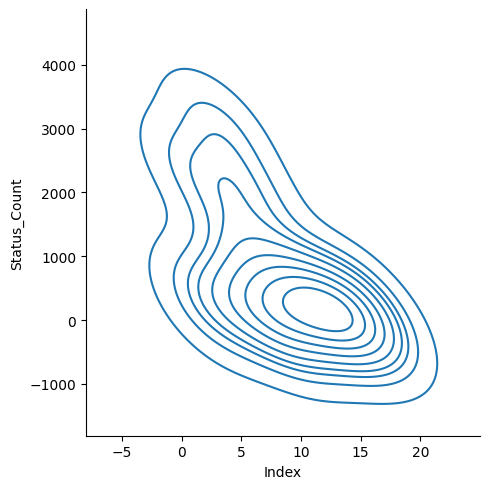

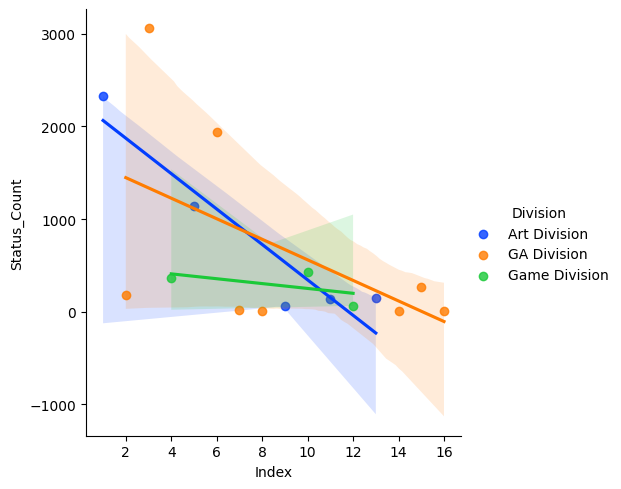

In [8]:
# FEATURES = ['Division','Department','CostCenterName','Location','ResourceLevel','JobTitle','JobFunction','Gender','Grade','MgrResourceLevel','Avg annual bonus vs monthly base salary (previous year) ','Avg quarterly people review rating (last 3 times)','Avg Extra time hours/week(6 mths)','Avg Idle day ratio/month (3 mths)','Avg Inefficiency/month (3 mths)','Avg Occupation ratio/month (3 mths)','Job Satisfaction','Personal Development (satisfaction)','Support from Company','Last quarterly people review rating','Last annual performance rating','Service Years','Promotion frequency/last 2 yrs.','Avg Salary CR/month(6 mths)','Salary adjustment frequency present year','Salary increment Delta vs last year (%)','Age'
# ]

# hue="species" - draw multiple histograms within the same graph
#date_time_col = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Data Transformation
test_df1 = df.copy(deep=True)
test_df1["Status_Count"] = test_df1.groupby(["Location"])["Status"].transform("sum")
test_df1 = test_df1.drop_duplicates(["Location"])
test_df1["Index"] = range(1, len(test_df1) + 1)
print(test_df1[["Index", "Location", "Status_Count"]].head(5))

## Distribution Plots
# High level plots:
#hist_plot = sns.displot(data=test_df1, x="Division", y="Status_Count", kind="hist", hue="Location", palette="bright")
kde_plot = sns.displot(data=test_df1, x="Index", y="Status_Count", kind="kde") # kde x axis must be numerical / datetime 
# for hist => hue will be a sub group by col that can be inputted

# Low level plots: 
#ecdf_plot = sns.displot(data=test_df1, x="Status_Count", kind="ecdf", hue="Status", palette="bright") # only one variable needed => a probability distribution is plotted. ecdf vs cdf: cdf is based on hypothetitical but ecdf is empirical(actual) data

## Categorical plots
# High level plots:
#bar_plot = sns.catplot(data=test_df1, x="Division", y="Status_Count", kind="bar") #Error bars give the precision of the measurement 
#box_plot = sns.catplot(data=test_df1, x="Division", y="Status_Count", kind="box", hue="Status", palette="bright")

# Low level plots:
#swarm_plot = sns.catplot(data=test_df1, x="Status_Count", y="Location", kind="swarm", hue="Division", palette="bright")

## Relational plots
# High level plots:
#scatter_plot = sns.relplot(data=test_df1, x="Service Years", y="Status_Count", kind="scatter", hue="Division", palette="bright")
#line_plot = sns.relplot(data=test_df1, x="Status_Count", y="Location", kind="line", hue="Division", palette="bright")

## Regression plots
# High level plots
lm_plot = sns.lmplot(data=test_df1, x="Index", y="Status_Count", hue="Division", palette="bright")

In [32]:
## Fully automated function (WIP)

combined_col = []
pri_cols = ["Division", "Location", "ResourceLevel"]
sec_col = ["Division", "Location"]
list_of_val_cols_calc = ["Department"]
list_of_val_cols_nocalc = ["Service Years", "Age"]

current_dir = os.getcwd()
current_datetime = datetime.datetime.now().strftime("%d.%m.%Y_%H%M")
dest_path = current_dir+'\\'+current_datetime + "_Visualisation"
if not os.path.exists(dest_path):
    os.makedirs(dest_path)

mapping = {
    "EmployeeID": "Categorical",
    "Division": "categorical",
    "Department": "categorical",
    "CostCenterName": "categorical",
    "CostCenterCode": "categorical",
    "Location": "categorical",
    "ResourceLevel": "categorical",
    "JobTitle": "categorical",
    "JobFunction": "categorical",
    "Style": "categorical",
    "Status": "categorical",
    "OnboardDate": "datetime",
    "TerminatedDate": "datetime",
    "Gender": "categorical",
    "Birthday": "datetime",
    "Grade": "categorical",
    "LineManager": "categorical",
    "LineManager": "categorical",
    "Nationality": "categorical",
    "EmployeeType": "categorical",
    "MgrResourceLevel": "categorical",
    "K/H": "categorical",
    "Voluntary": "categorical",
    "ResignationType": "categorical",
    "ResignationReason": "categorical",
    "Medical leave day (6 mths)": "numerical",
    "Service Years": "numerical",
    "Age": "numerical",
    "Job Satisfaction": "numerical",
    "Personal Development (satisfaction)": "numerical",
    "Support from Company": "numerical",
    "Avg Annual leave days taken/month (6 mths)": "numerical",
    "Promotion frequency/last 2 yrs.": "numerical",
    "Month in current level": "numerical",
    "Avg Extra time hours/week(6 mths)": "numerical",
    "Last annual performance rating": "numerical" 
}
### START OF SAVING VISUALS FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def save_viz(file_name):
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90, horizontalalignment = "right")
    plt.savefig(os.path.join(dest_path, file_name), dpi=300, bbox_inches='tight')
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF SAVING VISUALS FUNCTION

### START OF PLOTTING FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def label_checker(x_label: str, hue_label: str):
    if x_label == hue_label:
        return False
    else:
        return True

def hist_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"HistPlot_of_{x_label}_and_{y_label}.png"
    sns.displot(data=viz_df, x=x_label, y=y_label, kind="hist", hue=hue_label, palette="bright")
    save_viz(file_name)

def kde_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"KDEPlot_of_{x_label}_and_{y_label}.png"
    sns.displot(data=viz_df, x=x_label, y=y_label, kind="kde", hue=hue_label, palette="bright") 
    save_viz(file_name)

def bar_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"BarPlot_of_{x_label}_and_{y_label}.png"
    # print("x: " + str(x_label) + "\n")
    # print("y: " + str(y_label) + "\n")
    # print("Hue: " + str(hue_label) + "\n")
    sns.catplot(data=viz_df, x=x_label, y=y_label, kind="bar", hue=hue_label, palette="bright")
    save_viz(file_name)

def box_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"BoxPlot_of_{x_label}_and_{y_label}.png"
    sns.catplot(data=viz_df, x=x_label, y=y_label, kind="box", hue=hue_label, palette="bright")
    save_viz(file_name)

def swarm_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"SwarmPlot_of_{x_label}_and_{y_label}.png"
    sns.catplot(data=viz_df, x=x_label, y=y_label, kind="swarm", hue=hue_label, palette="bright")
    save_viz(file_name)

def scatter_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"ScatterPlot_of_{x_label}_and_{y_label}.png"
    sns.relplot(data=viz_df, x=x_label, y=y_label, kind="scatter", hue=hue_label, palette="bright")
    save_viz(file_name)

def line_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"LinePlot_of_{x_label}_and_{y_label}.png"
    sns.relplot(data=viz_df, x=x_label, y=y_label, kind="line", hue=hue_label, palette="bright")
    save_viz(file_name)

def lm_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"LMPlot_of_{x_label}_and_{y_label}.png"
    sns.lmplot(data=viz_df, x=x_label, y=y_label, hue=hue_label, palette="bright")
    save_viz(file_name)

def ecdf_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str):
    file_name = f"ECDFPlot_of_{x_label}.png"
    sns.displot(data=viz_df, x=x_label, kind="ecdf", hue=hue_label, palette="bright")
    save_viz(file_name)

def viz(viz_df: pd.DataFrame, x_label_list: list, hue_label: list, y_label_list: list):
    hue_label = ''.join(hue_label)
    for x_label in x_label_list:
        for y_label in y_label_list:
            if (mapping[x_label] == "categorical" or mapping[x_label] == "datetime") and (mapping[y_label] == "numerical") and (label_checker(x_label, hue_label) == True):
                bar_plot(viz_df, x_label, hue_label, y_label)
                #box_plot(viz_df, x_label, hue_label, y_label)

            elif (mapping[x_label] == "numerical" or mapping[x_label] == "datetime") and (mapping[y_label] == "numerical") and (label_checker(x_label, hue_label) == True):

                kde_plot(viz_df, x_label, hue_label, y_label)
                #line_plot(viz_df, x_label, hue_label, y_label)
            
            elif (mapping[x_label] == "numerical" or mapping[x_label] == "datetime") and (mapping[y_label] == "numerical" or mapping[y_label] == "datetime"):
                if label_checker(x_label, hue_label) == True:
                    lm_plot(viz_df, x_label, hue_label, y_label)

            elif (mapping[x_label] == "categorical" or mapping[x_label] == "datetime") and (mapping[x_label] == "numerical"):
                if label_checker(x_label, hue_label) == True:
                    hist_plot(viz_df, x_label, hue_label, y_label)
                    # scatter_plot(viz_df, x_label, hue_label, y_label)
                    # swarm_plot(viz_df, x_label, hue_label, y_label)
                
            elif (mapping[x_label] == "categorical" or mapping[x_label] == "numerical" or mapping[x_label] == "datetime"):
                if label_checker(x_label, hue_label) == True:
                    ecdf_plot(viz_df, x_label, hue_label)
                

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF PLOTTING FUNCTION

### START OF CALCULATED TABLE FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def table_calc(input_df_calc: pd.DataFrame, pri_cols_calc: list,sec_col_calc: list, val_col_calc: list, val_col_nocalc: list = []):
    original_val_col_calc = copy.deepcopy(val_col_calc)
    print(original_val_col_calc)
    try:
        group_by_col = pri_cols_calc + sec_col_calc
        group_by_col = list(dict.fromkeys(group_by_col))
        combined_col = group_by_col + val_col_calc + val_col_nocalc
    except Exception as e:
        print("Error was: " + str(e))

    test_df = input_df_calc.loc[:, combined_col]
    # for loop for val cols
    val_col_calc = copy.deepcopy(original_val_col_calc)
    for val in val_col_calc:
        # for loop to generate cols for val cols
        unique_vals = []
        new_col_name = ""
        new_col_name_list = []
        unique_vals = list(set(df[val])) # gives me the names of the unique vals within the values col
        num_unique_vals = len(unique_vals)

        for i in range(num_unique_vals):
            eval_col = np.where(test_df[val] == unique_vals[i], 1, 0)# unique vals is status, voluntary words
            # creating the name of the col
            new_col_name = f"Count_of_{val}_{unique_vals[i]}"
            # creating the col in the df
            print("eval col is:"+str(eval_col))

            test_df[new_col_name] = eval_col.flatten()
            test_df[new_col_name] = test_df.groupby(group_by_col, as_index=True)[new_col_name].transform("sum")
            new_col_name_list.append(new_col_name)
        test_df = test_df.drop([val], axis=1)

    for i in new_col_name_list:
        val_col_calc.append(i)
        mapping[i] = "numerical"
            
    test_df = test_df.drop_duplicates(group_by_col)
    val_col_calc += val_col_nocalc
    # print("non calc val cols are: " + str(val_col_nocalc))

    # print("Val col calc is: "+str(val_col_calc))

    #viz(test_df, pri_cols_calc, sec_col_calc, val_col_calc)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF CALCULATED TABLE FUNCTION

### START OF INITIALISATION FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def initialisation(calc_needed: bool, input_df_initialisation: pd.DataFrame, df_mapping: dict, pri_cols_initialisation: list = [], sec_col_initialisation: list = [], val_col_initialisation: list = [], val_col_initialisation_nocalc: list = []):
    counter = 0
    initial_val_cols = copy.deepcopy(val_col_initialisation)
    
    if (pri_cols_initialisation == []) and (sec_col_initialisation == []) and (val_col_initialisation == [] and (val_col_initialisation_nocalc == [])):
        for keys,values in df_mapping.items():
            try:
                if values == "categorical":
                    pri_cols_initialisation.append(keys)
                    sec_col_initialisation.append(keys)
                    val_col_initialisation.append(keys)

                elif values == "numerical" or values == "datetime":
                    val_col_initialisation_nocalc.append(keys)
        
            except Exception as e:
                print("Your error is: " + str(e))
                break
    
    if len(sec_col_initialisation) != 1:
        lists_of_sec_cols = [sec_col_initialisation[x: x+1] for x in range(0, len(sec_col_initialisation), 1)]
        for a in range(len(lists_of_sec_cols)):
            sec_col_initialisation = lists_of_sec_cols[a]
            if counter != 0:
                val_col_initialisation = copy.deepcopy(initial_val_cols)
            if calc_needed == True:
                table_calc(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation, val_col_initialisation_nocalc)
                counter += 1
            else:
                val_col_initialisation = val_col_initialisation + val_col_initialisation_nocalc
                viz(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
    else: 
        if calc_needed == True:
            table_calc(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation, val_col_initialisation_nocalc)
        else:
            val_col_initialisation = val_col_initialisation + val_col_initialisation_nocalc
            viz(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF INITIALISATION FUNCTION
initialisation(1, df, mapping)
#initialisation(1, df, mapping, pri_cols, sec_col, list_of_val_cols_calc, list_of_val_cols_nocalc) # only this will not have an int


Count_of_Age_nan
Count_of_Age_nan
Count_of_Age_36.70684932
Count_of_Age_36.53424658
Count_of_Age_18.98356164
Count_of_Age_19.6
Count_of_Age_20.0
Count_of_Age_21.81917808
Count_of_Age_21.76712329
Count_of_Age_23.16438356
Count_of_Age_24.30684932
Count_of_Age_24.77260274
Count_of_Age_25.17808219
Count_of_Age_27.49589041
Count_of_Age_28.36438356
Count_of_Age_28.77808219
Count_of_Age_30.56164384
Count_of_Age_25.8
Count_of_Age_27.2109589
Count_of_Age_28.34246575
Count_of_Age_29.80821918
Count_of_Age_30.55068493
Count_of_Age_30.66575342
Count_of_Age_30.4109589
Count_of_Age_33.84109589
Count_of_Age_31.65479452
Count_of_Age_32.0109589
Count_of_Age_33.69315068
Count_of_Age_34.61643836
Count_of_Age_36.09589041
Count_of_Age_38.40821918
Count_of_Age_36.02465753
Count_of_Age_37.49315068
Count_of_Age_38.0739726
Count_of_Age_39.85205479
Count_of_Age_40.74246575
Count_of_Age_43.60821918
Count_of_Age_44.69589041
Count_of_Age_45.24383562
Count_of_Age_46.2630137
Count_of_Age_46.67123288
Count_of_Age_48.5

C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_36.43561644
Count_of_Age_31.70136986
Count_of_Age_32.29863014
Count_of_Age_32.53972603
Count_of_Age_32.8739726
Count_of_Age_32.41369863
Count_of_Age_32.05753425
Count_of_Age_33.05753425


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_33.17260274
Count_of_Age_33.94246575
Count_of_Age_25.86027397
Count_of_Age_25.68767123
Count_of_Age_34.70136986
Count_of_Age_34.88493151
Count_of_Age_34.58630137
Count_of_Age_25.10136986


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_33.11506849
Count_of_Age_35.24109589
Count_of_Age_28.56438356
Count_of_Age_28.15068493
Count_of_Age_35.1260274
Count_of_Age_25.89589041
Count_of_Age_36.52876712


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_36.88493151
Count_of_Age_36.0
Count_of_Age_36.17260274
Count_of_Age_36.05753425
Count_of_Age_37.70136986
Count_of_Age_37.41369863
Count_of_Age_36.41369863
Count_of_Age_36.82739726
Count_of_Age_23.98356164


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_38.94246575
Count_of_Age_38.41369863
Count_of_Age_38.53972603
Count_of_Age_38.24109589
Count_of_Age_39.28767123
Count_of_Age_39.0
Count_of_Age_39.11506849
Count_of_Age_40.8739726


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_32.85479452
Count_of_Age_32.68219178
Count_of_Age_41.47123288
Count_of_Age_42.0


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_24.8109589
Count_of_Age_43.05753425
Count_of_Age_26.02191781
Count_of_Age_45.28767123
Count_of_Age_46.28767123
Count_of_Age_51.29863014
Count_of_Age_27.39726027
Count_of_Age_58.71232877
Count_of_Age_30.10136986


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_23.92054795
Count_of_Age_28.98356164
Count_of_Age_24.50684932
Count_of_Age_32.44657534
Count_of_Age_21.06849315
Count_of_Age_22.95342466
Count_of_Age_22.24109589
Count_of_Age_22.94246575


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_26.20547945
Count_of_Age_26.50684932
Count_of_Age_23.95342466
Count_of_Age_23.52876712
Count_of_Age_23.06849315
Count_of_Age_23.65479452
Count_of_Age_23.82739726
Count_of_Age_24.36712329
Count_of_Age_24.94246575
Count_of_Age_24.24109589
Count_of_Age_24.82739726
Count_of_Age_24.35616438
Count_of_Age_25.94246575
Count_of_Age_25.1260274
Count_of_Age_25.95342466
Count_of_Age_25.52876712


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_25.06849315
Count_of_Age_26.95342466
Count_of_Age_26.36712329
Count_of_Age_26.52876712
Count_of_Age_26.24109589
Count_of_Age_26.65479452
Count_of_Age_27.53972603
Count_of_Age_27.36712329


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_26.82739726
Count_of_Age_27.82739726
Count_of_Age_27.65479452
Count_of_Age_28.53972603
Count_of_Age_28.35616438
Count_of_Age_27.06849315


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_27.35616438
Count_of_Age_28.52876712
Count_of_Age_29.36712329
Count_of_Age_29.52876712
Count_of_Age_29.24109589
Count_of_Age_28.95342466
Count_of_Age_29.35616438
Count_of_Age_30.95342466
Count_of_Age_30.94246575
Count_of_Age_31.06849315


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_31.1260274
Count_of_Age_31.24109589
Count_of_Age_25.21643836
Count_of_Age_25.63013699
Count_of_Age_31.35616438
Count_of_Age_36.75890411
Count_of_Age_26.39178082
Count_of_Age_26.21917808
Count_of_Age_23.87671233
Count_of_Age_23.29041096


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_32.50684932
Count_of_Age_24.87671233
Count_of_Age_25.87671233
Count_of_Age_28.16712329
Count_of_Age_26.4630137
Count_of_Age_29.16712329
Count_of_Age_19.19452055
Count_of_Age_27.29041096
Count_of_Age_21.89589041


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_21.48219178
Count_of_Age_21.59726027
Count_of_Age_22.59726027
Count_of_Age_22.76986301
Count_of_Age_22.30958904
Count_of_Age_23.90684932
Count_of_Age_23.48219178
Count_of_Age_23.19452055


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_23.78082192
Count_of_Age_23.89589041
Count_of_Age_24.76986301
Count_of_Age_24.0109589
Count_of_Age_24.89589041
Count_of_Age_23.0109589
Count_of_Age_24.48219178
Count_of_Age_25.0109589
Count_of_Age_25.60821918
Count_of_Age_25.48219178
Count_of_Age_25.18356164


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_25.76986301
Count_of_Age_26.59726027
Count_of_Age_26.78082192
Count_of_Age_26.89589041
Count_of_Age_26.19452055
Count_of_Age_26.90684932
Count_of_Age_27.90684932
Count_of_Age_27.60821918
Count_of_Age_27.48219178
Count_of_Age_26.48219178


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_26.0109589
Count_of_Age_28.18356164
Count_of_Age_28.60821918
Count_of_Age_28.19452055
Count_of_Age_28.0109589
Count_of_Age_28.48219178
Count_of_Age_29.90684932
Count_of_Age_29.30958904
Count_of_Age_29.48219178
Count_of_Age_29.59726027


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_28.59726027
Count_of_Age_30.89589041
Count_of_Age_30.60821918
Count_of_Age_29.76986301
Count_of_Age_32.51232877
Count_of_Age_31.18356164
Count_of_Age_31.89589041
Count_of_Age_31.78082192
Count_of_Age_31.48219178
Count_of_Age_27.26575342
Count_of_Age_32.1369863


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_32.48219178
Count_of_Age_32.35616438
Count_of_Age_26.3890411
Count_of_Age_24.70958904
Count_of_Age_33.0109589
Count_of_Age_33.18356164
Count_of_Age_33.72328767
Count_of_Age_33.48219178
Count_of_Age_33.73424658
Count_of_Age_34.76986301


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_34.1369863
Count_of_Age_34.59726027
Count_of_Age_33.76986301
Count_of_Age_34.0109589
Count_of_Age_35.83835616
Count_of_Age_35.18356164
Count_of_Age_35.78082192
Count_of_Age_35.1369863
Count_of_Age_35.95342466


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_36.72328767
Count_of_Age_36.60821918
Count_of_Age_35.36712329
Count_of_Age_36.73424658
Count_of_Age_36.19452055
Count_of_Age_37.32054795
Count_of_Age_37.35616438
Count_of_Age_37.59726027
Count_of_Age_36.32054795
Count_of_Age_37.78082192


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_38.32054795
Count_of_Age_38.43561644
Count_of_Age_37.83835616
Count_of_Age_25.70958904
Count_of_Age_38.78082192
Count_of_Age_39.48219178
Count_of_Age_40.72328767
Count_of_Age_40.18356164
Count_of_Age_40.0109589
Count_of_Age_41.42465753
Count_of_Age_41.1369863


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_41.30958904
Count_of_Age_41.43561644
Count_of_Age_42.1369863
Count_of_Age_42.42465753
Count_of_Age_42.43561644
Count_of_Age_23.83287671
Count_of_Age_26.5369863
Count_of_Age_45.0109589
Count_of_Age_45.36712329
Count_of_Age_46.73424658
Count_of_Age_46.72328767


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_47.90684932
Count_of_Age_24.83287671
Count_of_Age_51.89589041
Count_of_Age_51.73424658
Count_of_Age_52.06849315
Count_of_Age_28.12328767
Count_of_Age_53.30958904
Count_of_Age_54.1369863
Count_of_Age_54.60821918
Count_of_Age_26.40273973


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_27.3890411
Count_of_Age_29.5369863
Count_of_Age_29.12328767
Count_of_Age_32.17260274
Count_of_Age_32.0
Count_of_Age_24.36986301
Count_of_Age_24.78356164
Count_of_Age_33.41369863
Count_of_Age_25.36986301


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_25.78356164
Count_of_Age_22.84931507
Count_of_Age_22.42465753
Count_of_Age_22.43561644
Count_of_Age_22.72328767
Count_of_Age_22.73424658
Count_of_Age_23.72328767
Count_of_Age_23.2630137
Count_of_Age_23.42465753
Count_of_Age_23.56164384
Count_of_Age_23.83835616


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_24.2630137
Count_of_Age_24.56164384
Count_of_Age_24.72328767
Count_of_Age_23.55068493
Count_of_Age_24.14794521
Count_of_Age_25.25205479
Count_of_Age_25.1369863
Count_of_Age_25.73424658
Count_of_Age_25.42465753
Count_of_Age_24.02191781
Count_of_Age_26.84931507
Count_of_Age_26.55068493


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_26.72328767
Count_of_Age_26.73424658
Count_of_Age_26.43561644
Count_of_Age_27.02191781
Count_of_Age_27.43561644
Count_of_Age_27.2630137
Count_of_Age_26.32054795
Count_of_Age_27.25205479
Count_of_Age_28.02191781
Count_of_Age_28.43561644
Count_of_Age_28.42465753
Count_of_Age_28.32054795
Count_of_Age_28.72328767


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_29.55068493
Count_of_Age_29.02191781
Count_of_Age_29.42465753
Count_of_Age_29.84931507
Count_of_Age_29.14794521
Count_of_Age_29.32054795
Count_of_Age_29.73424658
Count_of_Age_30.72328767
Count_of_Age_30.42465753
Count_of_Age_29.43561644
Count_of_Age_31.55068493


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_31.72328767
Count_of_Age_31.42465753
Count_of_Age_31.25205479
Count_of_Age_30.83835616
Count_of_Age_31.56164384
Count_of_Age_31.73424658
Count_of_Age_26.93150685
Count_of_Age_26.66575342
Count_of_Age_28.73150685
Count_of_Age_34.3890411
Count_of_Age_28.07945205
Count_of_Age_28.66575342


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_24.1890411
Count_of_Age_24.60273973
Count_of_Age_23.13972603
Count_of_Age_23.89863014
Count_of_Age_26.01643836
Count_of_Age_24.13972603
Count_of_Age_24.89863014
Count_of_Age_27.1890411
Count_of_Age_29.90410959
Count_of_Age_25.7260274
Count_of_Age_32.49315068


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_23.84931507
Count_of_Age_26.31232877
Count_of_Age_20.96438356
Count_of_Age_21.49315068
Count_of_Age_21.3890411
Count_of_Age_21.79178082
Count_of_Age_22.09041096
Count_of_Age_22.49315068
Count_of_Age_22.97534247
Count_of_Age_22.96438356
Count_of_Age_22.66575342


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Count_of_Age_23.67671233
Count_of_Age_23.49315068
Count_of_Age_23.09041096
Count_of_Age_23.07945205
Count_of_Age_23.37808219
Count_of_Age_24.49315068
Count_of_Age_24.09041096
Count_of_Age_24.79178082
Count_of_Age_24.3890411


C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\2235872124.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

KeyboardInterrupt: 

In [10]:
## Fully automated function (WIP)

combined_col = []
pri_cols = ["Division", "Department"]
sec_col = ["ResourceLevel", "Location"]
list_of_val_cols = ["Status"]

current_dir = os.getcwd()
current_datetime = datetime.datetime.now().strftime("%d.%m.%Y_%H%M")
dest_path = current_dir+'\\'+current_datetime + "_Visualisation"
if not os.path.exists(dest_path):
    os.makedirs(dest_path)

mapping = {
    "EmployeeID": "Categorical",
    "Division": "categorical",
    "Department": "categorical",
    "CostCenterName": "categorical",
    "CostCenterCode": "categorical",
    "Location": "categorical",
    "ResourceLevel": "categorical",
    "JobTitle": "categorical",
    "JobFunction": "categorical",
    "Style": "categorical",
    "Status": "categorical",
    "OnboardDate": "datetime",
    "TerminatedDate": "datetime",
    "Gender": "categorical",
    "Birthday": "datetime",
    "Grade": "categorical",
    "LineManager": "categorical",
    "LineManager": "categorical",
    "Nationality": "categorical",
    "EmployeeType": "categorical",
    "MgrResourceLevel": "categorical",
    "K/H": "categorical",
    "Voluntary": "categorical",
    "ResignationType": "categorical",
    "ResignationReason": "categorical",
    "Service Years": "numerical",
    "Age": "numerical",
    "Job Satisfaction": "numerical",
    "Personal Development (satisfaction)": "numerical",
    "Support from Company": "numerical",
    "Avg Annual leave days taken/month (6 mths)": "numerical",
    "Promotion frequency/last 2 yrs.": "numerical",
    "Month in current level": "numerical",
    "Avg Extra time hours/week(6 mths)": "numerical",
    "Last annual performance rating": "numerical" 
}
### START OF SAVING VISUALS FUNCTION
# 
#     "Medical leave day (6 mths)": "numerical",--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def save_viz(file_name):
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90, horizontalalignment = "right")
    plt.savefig(os.path.join(dest_path, file_name), dpi=300, bbox_inches='tight')
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF SAVING VISUALS FUNCTION

### START OF PLOTTING FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def hist_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"HistPlot_of_{x_label}_and_{y_label}.png"
    sns.displot(data=viz_df, x=x_label, y=y_label, kind="hist", hue=hue_label, palette="bright")
    save_viz(file_name)

def kde_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"KDEPlot_of_{x_label}_and_{y_label}.png"
    sns.displot(data=viz_df, x=x_label, y=y_label, kind="kde", hue=hue_label, palette="bright") 
    save_viz(file_name)

def bar_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"BarPlot_of_{x_label}_and_{y_label}.png"
    sns.catplot(data=viz_df, x=x_label, y=y_label, kind="bar", hue=hue_label, palette="bright")
    save_viz(file_name)

def box_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"BoxPlot_of_{x_label}_and_{y_label}.png"
    sns.catplot(data=viz_df, x=x_label, y=y_label, kind="box", hue=hue_label, palette="bright")
    save_viz(file_name)

def swarm_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"SwarmPlot_of_{x_label}_and_{y_label}.png"
    sns.catplot(data=viz_df, x=x_label, y=y_label, kind="swarm", hue=hue_label, palette="bright")
    save_viz(file_name)

def scatter_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"ScatterPlot_of_{x_label}_and_{y_label}.png"
    sns.relplot(data=viz_df, x=x_label, y=y_label, kind="scatter", hue=hue_label, palette="bright")
    save_viz(file_name)

def line_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"LinePlot_of_{x_label}_and_{y_label}.png"
    sns.relplot(data=viz_df, x=x_label, y=y_label, kind="line", hue=hue_label, palette="bright")
    save_viz(file_name)

def lm_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str, y_label: str):
    file_name = f"LMPlot_of_{x_label}_and_{y_label}.png"
    sns.lmplot(data=viz_df, x=x_label, y=y_label, hue=hue_label, palette="bright")
    save_viz(file_name)

def ecdf_plot(viz_df: pd.DataFrame, x_label: str, hue_label: str):
    file_name = f"ECDFPlot_of_{x_label}.png"
    sns.displot(data=viz_df, x=x_label, kind="ecdf", hue=hue_label, palette="bright")
    save_viz(file_name)

def viz(viz_df: pd.DataFrame, x_label_list: list, hue_label: list, y_label_list: list):
    hue_label = ''.join(hue_label)
    for x_label in x_label_list:
        for y_label in y_label_list:
            if (mapping[x_label] == "categorical" or mapping[x_label] == "datetime") and mapping[y_label] == "numerical":
                bar_plot(viz_df, x_label, hue_label, y_label)
                box_plot(viz_df, x_label, hue_label, y_label)

            elif (mapping[x_label] == "numerical" or mapping[x_label] == "datetime") and mapping[y_label] == "numerical":
                kde_plot(viz_df, x_label, hue_label, y_label)
                line_plot(viz_df, x_label, hue_label, y_label)
            
            elif (mapping[x_label] == "numerical" or mapping[x_label] == "datetime") and (mapping[y_label] == "numerical" or mapping[y_label] == "datetime"):
                lm_plot(viz_df, x_label, hue_label, y_label)

            elif (mapping[x_label] == "categorical" or mapping[x_label] == "datetime") and (mapping[x_label] == "numerical"):
                hist_plot(viz_df, x_label, hue_label, y_label)
                scatter_plot(viz_df, x_label, hue_label, y_label)
                swarm_plot(viz_df, x_label, hue_label, y_label)
                
            elif (mapping[x_label] == "categorical" or mapping[x_label] == "numerical" or mapping[x_label] == "datetime"):
                ecdf_plot(viz_df, x_label, hue_label)
                

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF PLOTTING FUNCTION

### START OF CALCULATED TABLE FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def table_calc(input_df_calc: pd.DataFrame, pri_cols_calc: list,sec_col_calc: list, val_col_calc: list):
    print("pri col is: " + str(pri_cols_calc) + "\n")
    print("sec col is: " + str(sec_col_calc)+ "\n")
    print("val col is: " + str(val_col_calc)+ "\n")
    
    try:
        group_by_col = pri_cols_calc + sec_col_calc
        group_by_col = list(dict.fromkeys(group_by_col))
        combined_col = group_by_col + val_col_calc
    except Exception as e:
        print("Error was: " + str(e))

    test_df = input_df_calc.loc[:, combined_col]
    # for loop for val cols
    for val in val_col_calc:
        # for loop to generate cols for val cols
        unique_vals = []
        new_col_name = ""
        new_col_name_list = []
        unique_vals = list(set(df[val])) # gives me the names of the unique vals within the values col
        num_unique_vals = len(unique_vals)

        for i in range(num_unique_vals):
            eval_col = np.where(test_df[val] == unique_vals[i], 1, 0)# unique vals is status, voluntary words
            # creating the name of the col
            new_col_name = f"Count_of_{val}_{unique_vals[i]}"
            # creating the col in the df
            test_df[new_col_name] = eval_col.flatten()
            test_df[new_col_name] = test_df.groupby(group_by_col)[new_col_name].transform("sum")
            new_col_name_list.append(new_col_name)
        test_df = test_df.drop([val], axis=1)

    for i in new_col_name_list:
        val_col_calc.append(i)
        mapping[i] = "numerical"
            
    test_df = test_df.drop_duplicates(group_by_col)
    viz(test_df, pri_cols_calc, sec_col_calc, val_col_calc)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF CALCULATED TABLE FUNCTION

### START OF INITIALISATION FUNCTION
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def initialisation(calc_needed: bool, input_df_initialisation: pd.DataFrame, df_mapping: dict, pri_cols_initialisation: list = [], sec_col_initialisation: list = [], val_col_initialisation: list = []):
    counter = 0
    initial_val_cols = copy.deepcopy(val_col_initialisation)
    
    if (pri_cols_initialisation == []) and (sec_col_initialisation == []) and (val_col_initialisation == []):
        for keys,values in df_mapping.items():
            try:
                if values == "categorical":
                    pri_cols_initialisation.append(keys)
                    sec_col_initialisation.append(keys)

                elif values == "numerical" or values == "datetime":
                    val_col_initialisation.append(keys)
        
            except Exception as e:
                print("Your error is: " + str(e))
                break
        
    if len(sec_col_initialisation) != 1:
        lists_of_sec_cols = [sec_col_initialisation[x: x+1] for x in range(0, len(sec_col_initialisation), 1)]
        for a in lists_of_sec_cols:
            # print(pri_cols_initialisation[a])
            # print(sec_col_initialisation[a])
            # if sec_col_initialisation[a] != pri_cols_initialisation[a]: 
            sec_col_initialisation = a
            # else:
            #     sec_col_initialisation = lists_of_sec_cols[a+1]
            print(sec_col_initialisation)
            if counter != 0:
                val_col_initialisation = copy.deepcopy(initial_val_cols)
            if calc_needed == True:
                table_calc(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
                counter += 1
            else:
                viz(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
    else:
        if calc_needed == True:
            table_calc(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
        else:
            viz(input_df_initialisation, pri_cols_initialisation, sec_col_initialisation, val_col_initialisation)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### END OF INITIALISATION FUNCTION

initialisation(1, df, mapping) # only this will not have an int

['Division']
pri col is: ['Division', 'Department', 'CostCenterName', 'CostCenterCode', 'Location', 'ResourceLevel', 'JobTitle', 'JobFunction', 'Style', 'Status', 'Gender', 'Grade', 'LineManager', 'Nationality', 'EmployeeType', 'MgrResourceLevel', 'K/H', 'Voluntary', 'ResignationType', 'ResignationReason']

sec col is: ['Division']

val col is: ['OnboardDate', 'TerminatedDate', 'Birthday', 'Service Years', 'Age', 'Job Satisfaction', 'Personal Development (satisfaction)', 'Support from Company', 'Avg Annual leave days taken/month (6 mths)', 'Promotion frequency/last 2 yrs.', 'Month in current level', 'Avg Extra time hours/week(6 mths)', 'Last annual performance rating']



C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\3872698242.py:164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\3872698242.py:164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name] = eval_col.flatten()
C:\Users\sphay\AppData\Local\Temp\ipykernel_14500\3872698242.py:164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

KeyboardInterrupt: 

In [27]:
sns.catplot(data=df, x="Location", y="OnboardDate", kind="box", hue="Division", palette="bright")

TypeError: Neither the `x` nor `y` variable appears to be numeric.

In [ ]:
# Poll list:
# 1) Games Night (offline or online)
# 2) Badminton 
# 3) Rock climbing 
# 4) 
